# Batch Effect detection class

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_selection import f_classif
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from umap import UMAP


def pca_emb(features,n_components=2):
    X_emb = StandardScaler().fit_transform(features)
    X_emb = PCA(n_components=n_components).fit_transform(X_emb)
    return numpy_to_dataframe(X_emb)

def tsne_emb(features,n_components=2):
    X_emb = StandardScaler().fit_transform(features)
    X_emb = TSNE(n_components).fit_transform(X_emb)
    return numpy_to_dataframe(X_emb)

def umap_emb(features,n_components=2):
    X_emb = StandardScaler().fit_transform(features)
    X_emb = UMAP(n_components=n_components).fit_transform(X_emb)
    return numpy_to_dataframe(X_emb)

def numpy_to_dataframe(X_emb):
    n_col = X_emb.shape[1]
    X_emb = pd.DataFrame(X_emb, columns=["PC" + str(i+1) for i in range(n_col)])
    return X_emb

class BatchDetect():
    """
    BatchDetect
    This class takes the metadata and features from any dataset
    and analyze whether there is a clear batch effect in the data.
    """
    def __init__(self, metadata, features):
        """
        Initializing the class with metadata and features.
        inputs:
            metadata (pd.DataFrame): The metadata needs to have dimension
            of (N,M) where N is the number of sampels and M is
            the number covariates.

            features (pd.DataFrame): The features need to have the dimension of
            (N,F) where N is the number of sampels and
            F is the number of features.
        """
        self.metadata = metadata
        self.features = features

    def low_dim_visualization(self, method = "pca"):
        """
        low dimensional visualization creates a 2D representation of the
        provided features and generates scatterplots based on the covariates
        in the metadata
        inputs:
            method (str): one of three options ["pca", "tsne", "umap"]
        """
        assert method.lower() in ["pca", "tsne", "umap"]

        if method == "pca":
            X_emb = pca_emb(self.features)
        elif method == "tsne":
            X_emb = tsne_emb(self.features)
        elif method == "umap":
            X_emb = umap_emb(self.features)

        ncols = self.metadata.shape[1]
        nrows = 1

        fig, ax = plt.subplots(nrows = nrows ,
                               ncols = ncols,
                               figsize = (5*ncols, 5*nrows),
                               sharex=True, sharey=True)
        for j in range(ncols):
            ax[j] = sns.scatterplot(x = X_emb.iloc[:,0],
                                    y = X_emb.iloc[:,1],
                                    hue = self.metadata.iloc[:,j],
                                   ax = ax[j])

    def prince_plot(self,n_components=5):
        """
        prince plot first generates a PCA embedding of the features. then
        it runs an ANOVA test of every principal componenet (PC) vs. the
        covariates of the metadata
        inputs:
            n_components (int): number of PCs in the PCA output
        """

        X_emb = pca_emb(self.features,
                        n_components=n_components)

        ncols = self.metadata.shape[1]
        nrows = n_components

        heatmap_mat = pd.DataFrame(0.,
                                   columns=self.metadata.columns,
                                   index = ["PC" + str(i) for i in range(n_components)])

        for i in range(nrows):
            for j in range(ncols):
                heatmap_mat.iloc[i,j] = f_classif(X_emb.iloc[:,i:i+1],
                                             self.metadata.iloc[:,j])[1][0]

        fig, ax = plt.subplots(figsize = (1*ncols, 1*nrows))

        ax = sns.heatmap(heatmap_mat,
                         cmap = "Greys_r",
                         annot=True,
                         fmt=".3f",
                         ax = ax,
                         vmin = 0,
                         vmax = 0.05)

    def classification_test(self,
                            scorer="accuracy",
                            n_splits = 5,
                            n_repeats = 10):
        """
        classification test runs two classifiers. One is a DummyClassifier from
        sklearn with uniform strategy and the next one is a
        RandomForestClassifier. The target variables are based on the covariates
        in the metadata dataframe. If the Randomforst works better than the
        DummyClassifier, it means that there is a systematic batch effect for
        that specific covariate.
        inputs:
            scorer (str): the metric for the classification performance
            n_splits (int): number of splits of the data for
            RepeatedStratifiedKFold
            n_repeats (int): number of repeats of the data for
            RepeatedStratifiedKFold

        """

        results = dict()

        results["covariate"] = []
        results[scorer] = []
        results["method"] = []

        for col in self.metadata.columns:

            random_results = cross_val_score(
                estimator = DummyClassifier(strategy = "uniform"),
                    X = self.features,
                    y = self.metadata.loc[:,col],
                    cv = RepeatedStratifiedKFold(n_splits=n_splits,
                                                 n_repeats=n_repeats),
                    scoring=scorer
            )

            results["covariate"] +=[col]*n_splits*n_repeats
            results["method"] +=["random"]*n_splits*n_repeats
            results[scorer] +=random_results.tolist()

            rf_results = cross_val_score(
                estimator = RandomForestClassifier(),
                    X = self.features,
                    y = self.metadata.loc[:,col],
                    cv = RepeatedStratifiedKFold(n_splits=n_splits,
                                                n_repeats=n_repeats),
                    scoring=scorer
            )

            results["covariate"] +=[col]*n_splits*n_repeats
            results["method"] +=["random forest"]*n_splits*n_repeats
            results[scorer] +=rf_results.tolist()

        results = pd.DataFrame(results)


        fig, ax = plt.subplots(figsize = (len(self.metadata.columns), 2))

        ax = sns.boxplot(data = results,
                         x = "feature",
                        y = scorer,
                        hue = "method",
                        ax = ax)
        ax.legend(loc=(1.04, 0))

## creating a multi feature multi label dataset

In [2]:
from sklearn.datasets import make_multilabel_classification as make_ml_clf

X, Y = make_ml_clf(
        n_samples=200,
        n_features=20,
        n_classes=5,
        n_labels=4,
        allow_unlabeled=False,
    )

metadata = pd.DataFrame(Y, columns=["y1","y2","y3","y4","y5"])
features = X

X = Y = None

### lets assume each label is a source of batch effect

In [3]:
bd = BatchDetect(metadata, features)

# visualization with multiple labels

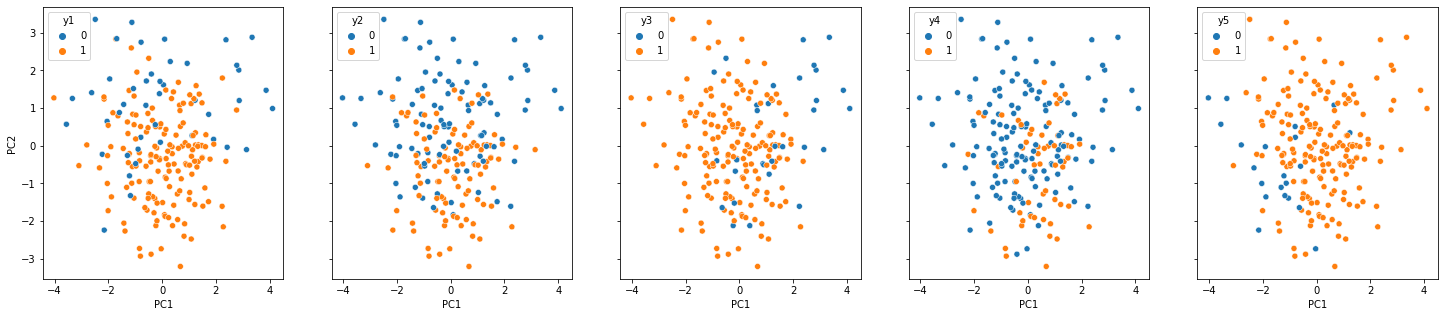

In [4]:
bd.low_dim_visualization("pca")

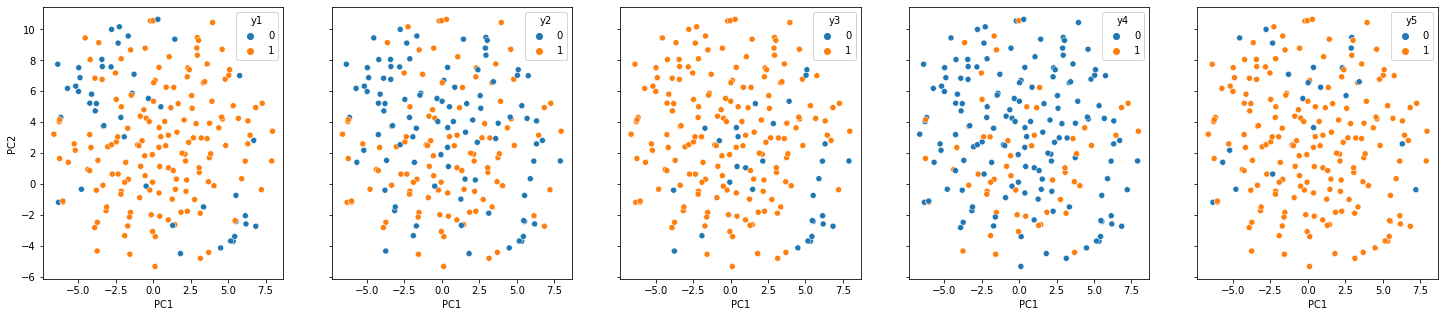

In [5]:
bd.low_dim_visualization("tsne")

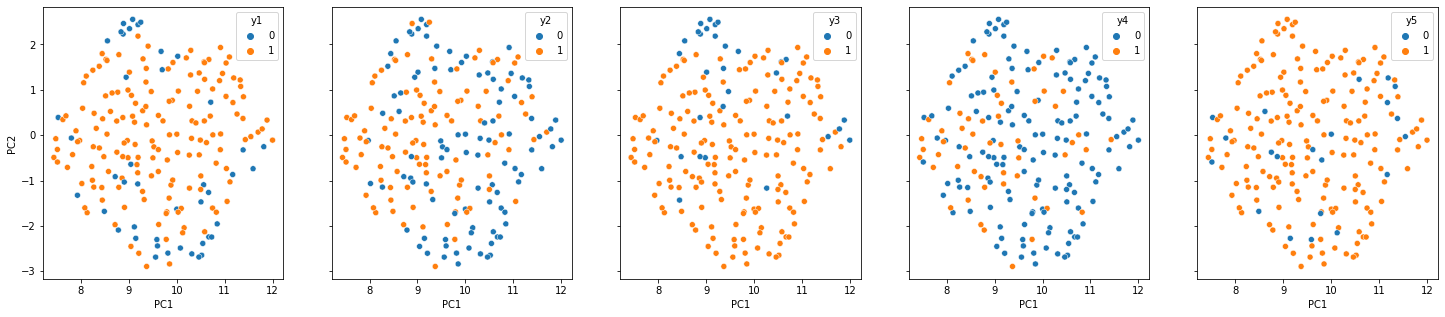

In [6]:
bd.low_dim_visualization("umap")

# Anova test of principal components vs. labels

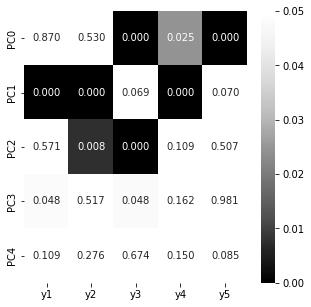

In [7]:
bd.prince_plot()

## classification test of  RF vs a random classifier

ValueError: Could not interpret input 'feature'

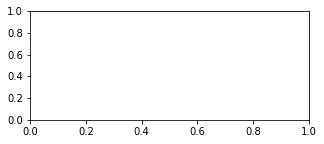

In [8]:
bd.classification_test(scorer="f1_macro")